## 「ベイズ推論による機械学習入門」P.128 ポアソン混合モデルにおけるギブスサンプリング

### ポアソン混合モデル

* クラスタkの観測モデルをポアソン分布とする（式1）。
* ポアソン分布のパラメータ $\lambda$ の事前分布をガンマ分布（共役事前分布）とする（式2）。
* 各クラスタの混合比率 $\pi$ はカテゴリ分布のため、事前分布をK次元のディリクレ分布（共役事前分布）とする（式3）。
* K個の観測モデルを各データ点に割り当てる潜在変数Sをカテゴリ分布とする（式4）。
* K個のポアソン分布に対して混合比率 $\pi$ を使って加重平均を取って各データ点に対する確率を求める（式5）。

$$\mathcal{p}(\mathcal{x}_n|\lambda_k) = Poi(\mathcal{x}_n|\lambda_k)\quad (1)$$

$$\mathcal{p}(\lambda_k) = Gam(\lambda_k|a, b)\quad (2)$$

$$\mathcal{p}(\pi) = Dir(\pi|\alpha)\quad (3)$$

$$\mathcal{p}(s_n|\pi) = Cat(s_n|\pi)\quad (4)$$

$$\sum_{k=1}^K \pi_k Poi(x_n|\lambda_k)\quad (5)$$


### 観測モデルの設定

In [2]:
using Distributions
using Plots

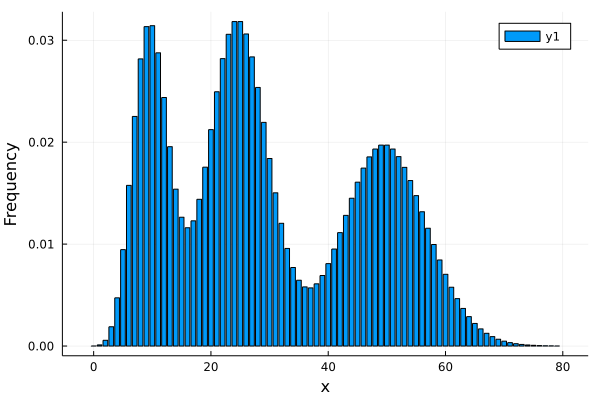

In [45]:
# ポアソン分布のパラメータを設定
𝛌 = [10.0, 25.0, 50.0]

# クラスタ数
K = length(𝛌)

# 混合比率を設定
𝛑 = [0.25, 0.4, 0.35]

# x軸を設定
xs = range(0, step=1, length=80)

# 確率計算、作図
prob = sum(k->𝛑[k] * pdf(Poisson(𝛌[k]), xs), 1:K)
bar(xs, prob)
plot!(xlabel="x", ylabel="Frequency")

### データの生成

潜在変数Sを生成し、各データに割り当てられたクラスタに従って観測データXを生成する。

In [41]:
# 潜在変数を生成
mul = Multinomial(1, 𝛑)
𝐒 = rand(mul, 100)

3×100 Array{Int64,2}:
 0  1  0  0  0  0  0  0  1  0  0  0  0  …  0  0  0  0  1  0  0  1  1  0  0  0
 0  0  0  0  1  0  1  1  0  1  1  0  1     1  1  1  0  0  1  0  0  0  0  1  0
 1  0  1  1  0  1  0  0  0  0  0  1  0     0  0  0  1  0  0  1  0  0  1  0  1

In [44]:
𝐒[:,1]

3-element Array{Int64,1}:
 0
 0
 1